Models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from helpers import coerce_into_full_datetime, add_missing_one_year_rows, plot_column, add_missing_dates, plot_rolling_correlations 
from helpers import interpret_p_value, plot_lagged_correlations, plot_increase_decades
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import polars as pl
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
import warnings
warnings.filterwarnings('ignore')


C:\Users\Lenovo IP320\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_combined_inner = pd.read_csv(r'df_combined_inner.csv')
df_full_CO2 = pd.read_csv(r'df_full_CO2.csv')

In [4]:
df_combined_inner["datetime"] = pd.to_datetime(df_combined_inner["datetime"]).dt.date
df_combined_inner.set_index("datetime", inplace=True)
df_combined_inner.index = pd.to_datetime(df_combined_inner.index, errors='coerce')

df_full_CO2["datetime"] = pd.to_datetime(df_full_CO2["datetime"]).dt.date
df_full_CO2.set_index("datetime", inplace=True)
df_full_CO2.index = pd.to_datetime(df_full_CO2.index, errors='coerce')

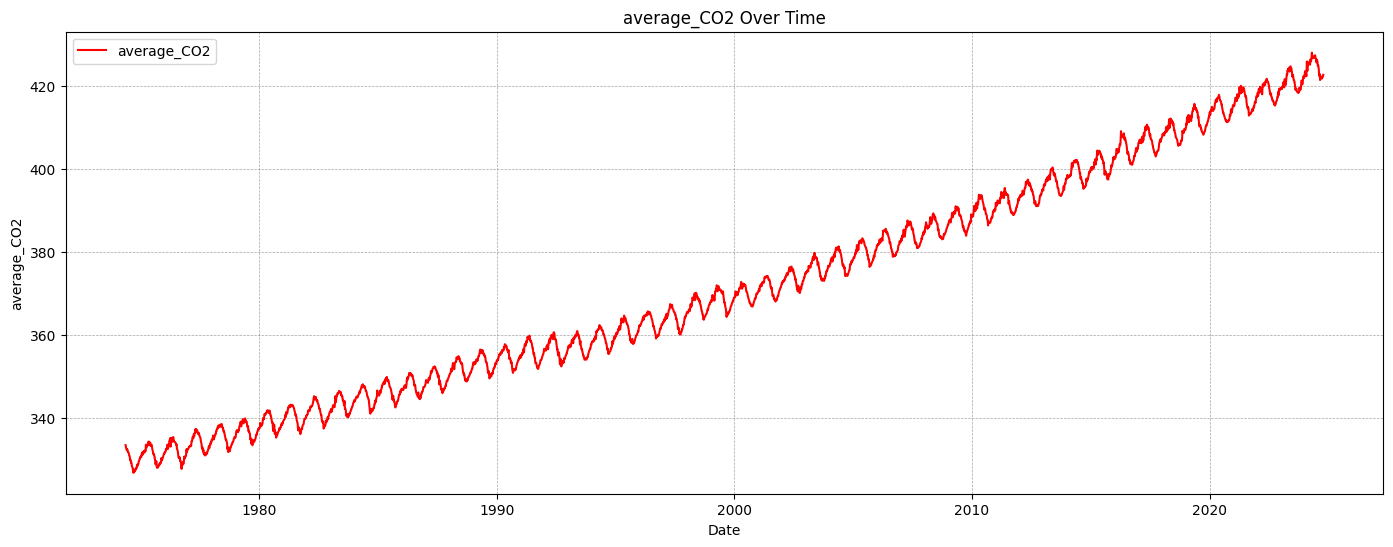

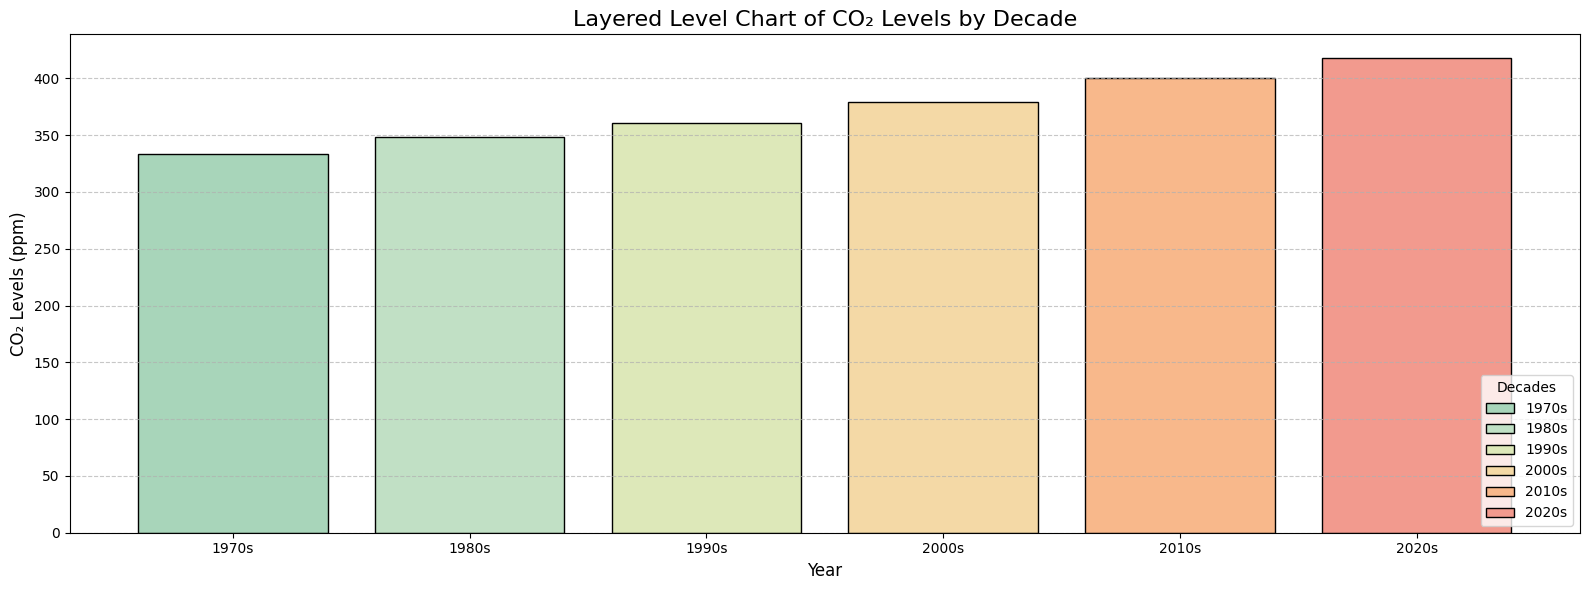

In [48]:
plot_column(df_full_CO2, 'average_CO2', 'red')
plot_increase_decades(df_full_CO2)

# 1. Long term Model - 10 years ahead - CO2 original data
# Gaussian Processes

In [49]:
# Step 1 - resample and structure data

df_CO2_monthly = df_full_CO2.resample('M').mean() # resampling by month
df_CO2_monthly.index = pd.to_datetime(df_CO2_monthly.index, errors='coerce')
df_CO2_monthly['average_CO2'] = df_CO2_monthly['average_CO2'].interpolate(method='time')
df_CO2_monthly = df_CO2_monthly.reset_index()

In [50]:
# Step 2. Transform datetime into a numeric representation (year + fractional month)

X = df_CO2_monthly["datetime"].dt.year + df_CO2_monthly["datetime"].dt.month / 12
X = X.to_numpy().reshape(-1, 1) # ensures the data is in a 2D array format required by scikit-learn

y = df_CO2_monthly["average_CO2"].to_numpy() # Target variable
 

In [51]:
# Step 3. Create and combine all necessary kernels 

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

seasonal_kernel = ( 
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
) 

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0) 

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

In [52]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel # combines all kernels

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

Gaussian Process Regression uses kernels to define how data points are related. Here we're creating a sophisticated kernel that captures different aspects of CO2 data. 

- `Long-term trend kernel`: Captures slow, gradual changes in CO2 levels
- `Seasonal kernel`: Models annual/cyclical variations
- `Irregularities kernel`: Handles short-term, non-periodic fluctuations
- `Noise kernel`: Accounts for measurement uncertainties

By adding these kernels, we create a comprehensive model that can capture complex patterns in CO2 measurements.

In [53]:
# Step 5. Train the model

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [54]:
# Step 6. Make predictions

# Calculating the last timestamp in your data as "year + fractional month"
last_timestamp = df_CO2_monthly["datetime"].max()
last_year_fractional = last_timestamp.year + last_timestamp.month / 12

X_test = np.linspace(start=last_year_fractional, stop=last_year_fractional + 10, num=1_000).reshape(-1, 1)

# Making the predictions
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean


We create 1,000 prediction points spanning the next 10 years.


`predict()` returns both the predicted mean and the standard deviation. The standard deviation represents the model's uncertainty at each point.
We add back the mean to convert predictions to absolute CO2 levels for the next 10 years.

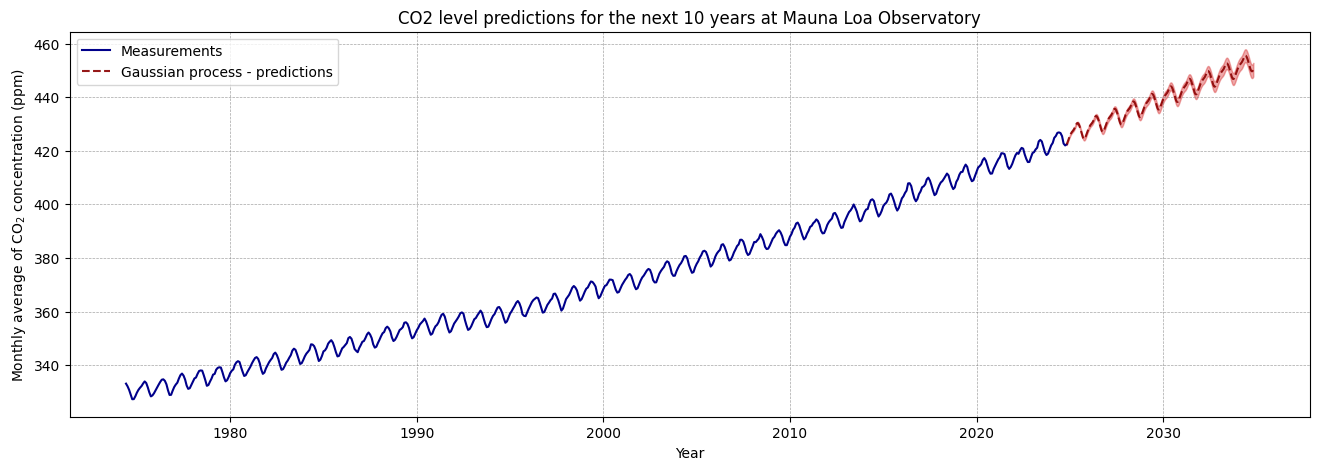

In [55]:
plt.figure(figsize=(16, 5))
plt.plot(X, y, color="darkblue", linestyle="-", label="Measurements")
plt.plot(X_test, mean_y_pred, linestyle="dashed",  color="darkred", alpha=0.9, label="Gaussian process - predictions")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:red",
    alpha=0.4,
)
plt.grid(
    color="gray",      
    linestyle="--",   
    linewidth=0.5,   
    alpha=0.7         
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title("CO2 level predictions for the next 10 years at Mauna Loa Observatory")

# 2. Short-Medium Model - predictions 1 month ahead
# SarimaX

In [18]:
# Load and prepare the dataset
data = df_combined_inner.copy()
co2_series = data['average_CO2'] # for such a short timeframe we don't really need all the features


In [19]:
# Step 1: Preprocess the data

co2_cleaned = co2_series.interpolate()
co2_diff = co2_cleaned.diff().dropna() # Differencing to remove trends

`diff()` calculates the difference between consecutive observations.

Differencing helps to:

- Remove underlying trends
- Stabilize the variance
- Make the time series more stationary (a key assumption for SARIMA models)

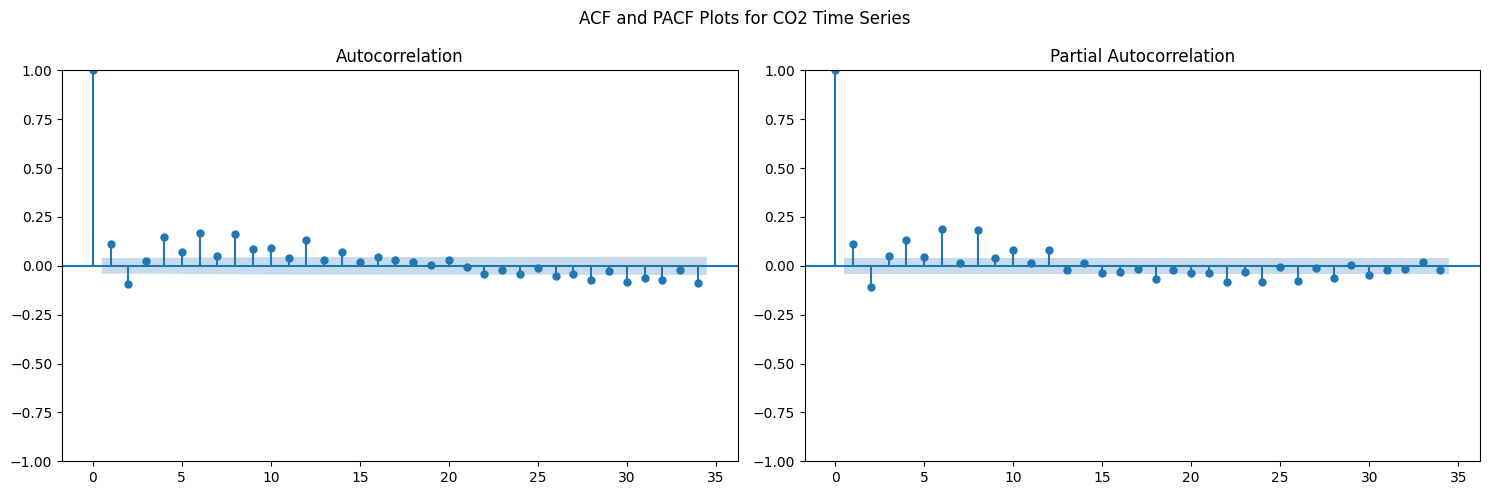

In [ ]:
# Step 2: ACF and PACF for diagnostics

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(co2_diff, ax=ax1)
plot_pacf(co2_diff, ax=ax2)
plt.suptitle('ACF and PACF Plots for CO2 Time Series')
plt.tight_layout()
plt.show()


**ACF** (Autocorrelation Function): Shows correlation between a series and its lagged versions

**PACF** (Partial Autocorrelation Function): Shows direct correlation between observations at different time lags

These plots help determine the appropriate parameters for the SARIMA model

Significant spikes indicate potential autoregressive (p) and moving average (q) terms

In [ ]:
# Step 3: finding best SARIMA order using grid search

pdq = [(0, 1, 1), (1, 1, 1), (1, 1, 2)]
seasonal_pdq = [(0, 1, 1, 12), (1, 1, 1, 12), (1, 1, 2, 12)]

best_aic = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(co2_diff, order=param, seasonal_order=seasonal_param)
            results = model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f"Best SARIMA Order: {best_order + best_seasonal_order}")


Best SARIMA Order: (1, 1, 2, 1, 1, 2, 12)


SARIMA model has multiple parameters:

- `p`: Number of autoregressive terms
- `d`: Degree of differencing
- `q`: Number of moving average terms
- Seasonal parameters add another layer for yearly (or other periodic) patterns


Grid search tests multiple parameter combinations
AIC (Akaike Information Criterion) helps select the best model

Balances model complexity with goodness of fit


The `12` in seasonal parameters suggests annual seasonality

In [22]:
# Step 4: Train the SARIMA model
model = SARIMAX(co2_series, 
                order=best_order, 
                seasonal_order=best_seasonal_order)
model_fit = model.fit()

In [23]:
# Step 5: Forecast next month's CO2 levels
steps = 30
forecast = model_fit.get_forecast(steps=steps)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [24]:
# Step 6: Visualize the extended forecast
# Historical range (last 5 months)
historical_range = co2_series.index[-5 * 30:]  # Approximately 5 months

In [25]:
# Forecast dates
forecast_dates = pd.date_range(start=co2_series.index[-1], periods=steps + 1)[1:]

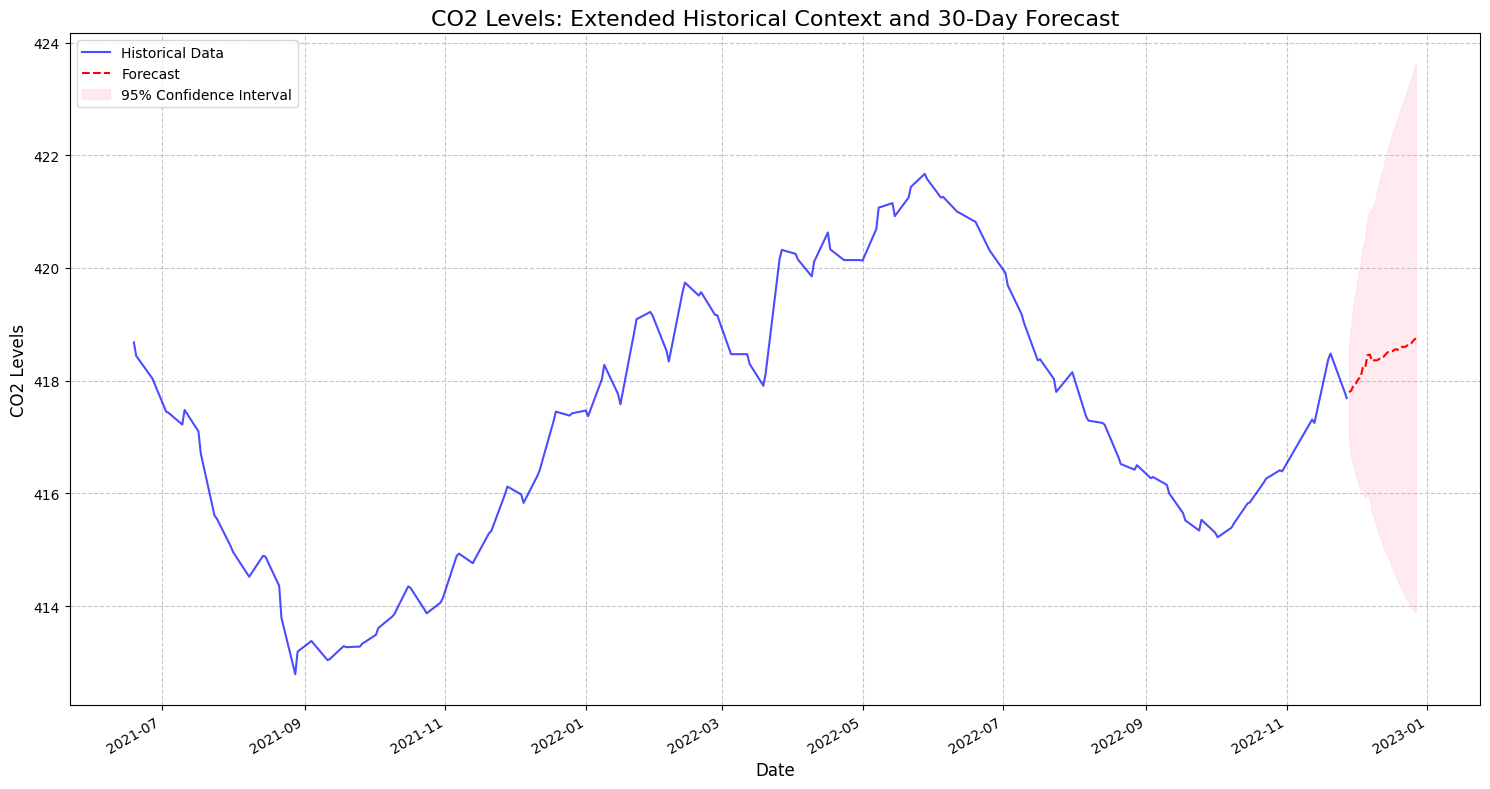

In [26]:
# plot
plt.figure(figsize=(15, 8))

# Plot extended historical data
plt.plot(historical_range, co2_series.loc[historical_range], 
         label='Historical Data', color='blue', alpha=0.7)

# Plot forecast
plt.plot(forecast_dates, predicted_mean, 
         label='Forecast', color='red', linestyle='--')

# confidence interval
plt.fill_between(forecast_dates, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, 
                 label='95% Confidence Interval')

# Formatting
plt.title('CO2 Levels: Extended Historical Context and 30-Day Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('CO2 Levels', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


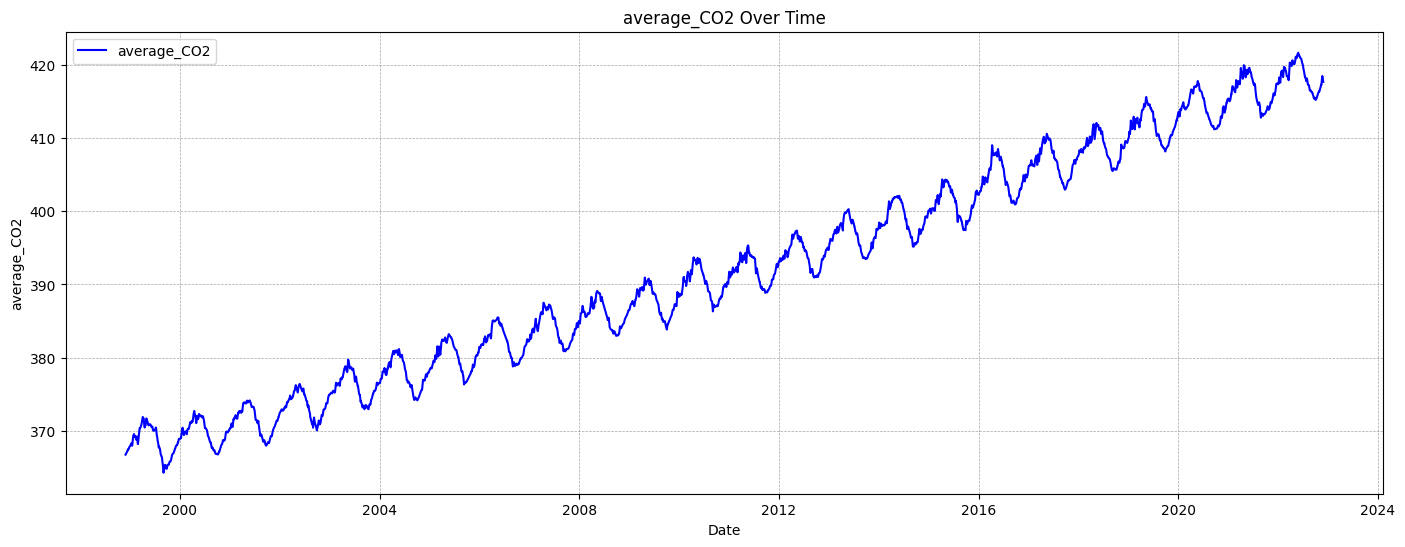

In [27]:
plot_column(df_combined_inner, 'average_CO2', 'blue')

# 3. Medium-Long term Model - predictions 5 years ahead
# Prophet

In [28]:
file_path = r'df_combined_inner.csv'
data = pd.read_csv(file_path, parse_dates=['datetime'])
prophet_df = data.rename(columns={'datetime': 'ds', 'average_CO2': 'y'})[['ds', 'y']]
prophet_df.dropna(inplace=True)

In [29]:
# Add other columns as regressors
other_columns = ['temperature', 'humidity', 'dew_point', 'precipitation', 'pressure',
                  'evapotranspiration', 'wind_speed', 'soil_temperature','value_CH4' ]  # Add your desired columns
for column in other_columns:
    prophet_df[column] = data[column]

In [30]:
# Initialize and Train Prophet Model
model = Prophet(
    changepoint_prior_scale=0.05,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    interval_width=0.95
)

In [31]:
# Add regressors
for column in other_columns:
    model.add_regressor(column)

model.fit(prophet_df)

13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:38 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Generate Future Forecast (5 years = ~1825 days)
# Generate future dataframe
future = model.make_future_dataframe(periods=5*365)

In [33]:
# Extend regressors into the future
for column in other_columns:
    future[column] = data[column].iloc[-1]  # Use the last known value as a constant
forecast = model.predict(future)

<Figure size 1600x800 with 0 Axes>

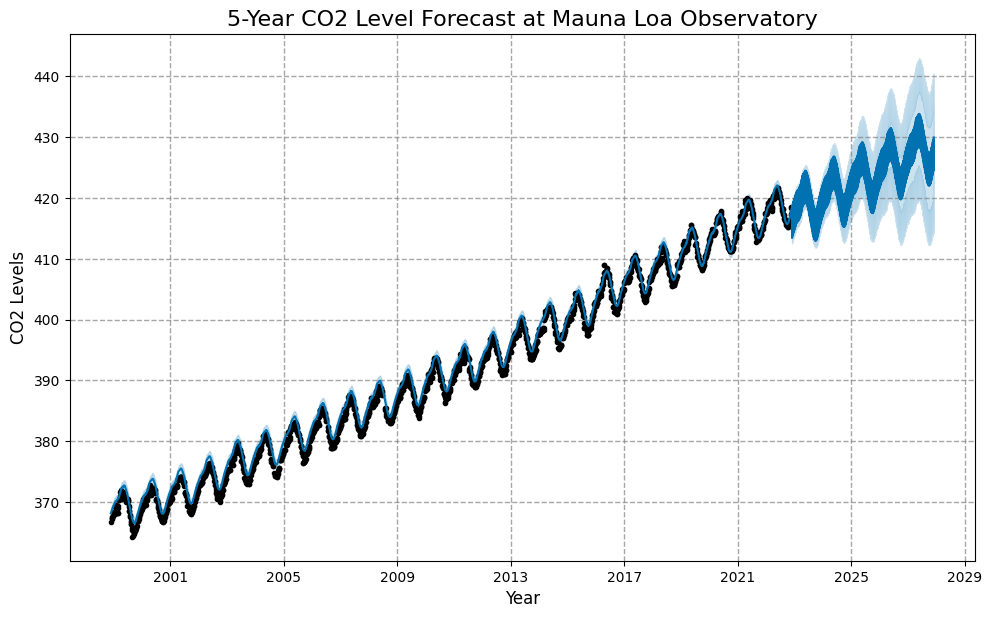

In [34]:
# Visualize the Forecast
plt.figure(figsize=(16, 8))
fig = model.plot(forecast)
plt.title('5-Year CO2 Level Forecast at Mauna Loa Observatory', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Levels', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [35]:
# Analyze Forecast Summary
forecast_summary = {
    'Start of Forecast': forecast['ds'].min(),
    'End of Forecast': forecast['ds'].max(),
    'Initial Predicted Value': forecast['yhat'].iloc[0],
    'Final Predicted Value': forecast['yhat'].iloc[-1],
    'Projected Change': forecast['yhat'].iloc[-1] - forecast['yhat'].iloc[0],
    'Minimum Predicted Value': forecast['yhat_lower'].min(),
    'Maximum Predicted Value': forecast['yhat_upper'].max(),
}

print("Forecast Summary:")
for key, value in forecast_summary.items():
    print(f"{key}: {value}")


Forecast Summary:
Start of Forecast: 1998-11-29 00:00:00
End of Forecast: 2027-11-26 00:00:00
Initial Predicted Value: 368.1372764212973
Final Predicted Value: 429.9399532730512
Projected Change: 61.80267685175386
Minimum Predicted Value: 365.67120508324723
Maximum Predicted Value: 443.0247579386379


# 4. Long term Model - predictions 20+ years ahead
# Gaussian Processes - all features

In [36]:
# Load dataset
df = pd.read_csv(r'df_combined_inner.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [37]:
# Resample and prepare data
df_monthly = df.resample('M').mean()
df_monthly.interpolate(method='time', inplace=True)
df_monthly.reset_index(inplace=True)

In [38]:
# Prepare features and target
X = (df_monthly['datetime'].dt.year + df_monthly['datetime'].dt.month / 12).to_numpy().reshape(-1, 1)
y = df_monthly['average_CO2'].to_numpy()

In [39]:
# Standardize target
y_mean = y.mean()
y_std = y.std()
y_normalized = (y - y_mean) / y_std

In [40]:
# Kernel selection
long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2 
    * RBF(length_scale=100.0) 
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel

In [41]:
# Fit Gaussian Process
gp = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gp.fit(X, y_normalized)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

In [42]:
# Prediction range
last_timestamp = df_monthly['datetime'].max()
last_year_fractional = last_timestamp.year + last_timestamp.month / 12
X_pred = np.linspace(last_year_fractional, last_year_fractional + 20, 240).reshape(-1, 1)

# Predictions
y_pred_normalized, std_pred = gp.predict(X_pred, return_std=True)
y_pred = y_pred_normalized * y_std + y_mean
std_pred *= y_std

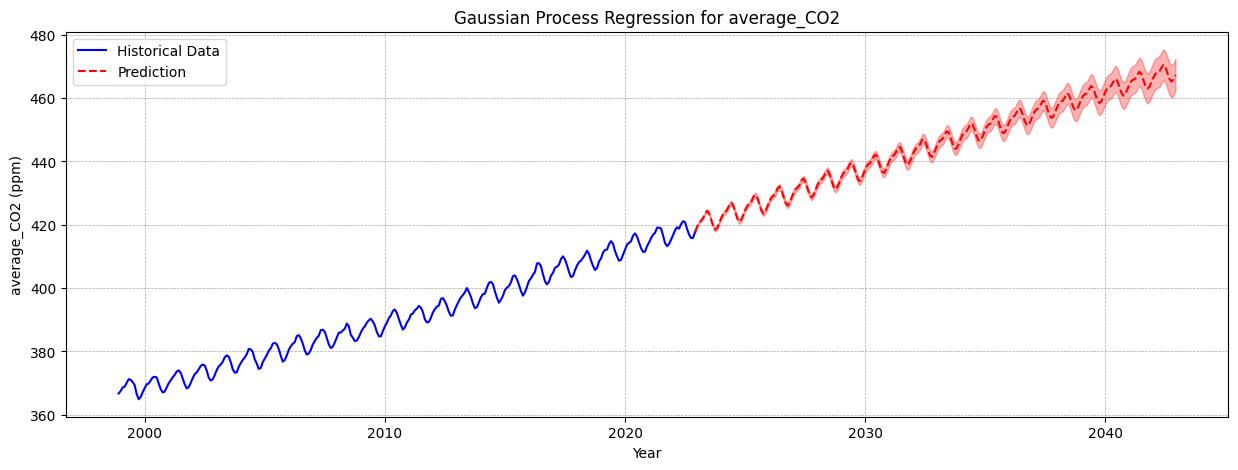

In [43]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(X, y, label='Historical Data', color='blue')
plt.plot(X_pred, y_pred, label='Prediction', color='red', linestyle='--')
plt.fill_between(X_pred.ravel(), y_pred - std_pred, y_pred + std_pred, alpha=0.3, color='red')
plt.title('Gaussian Process Regression for average_CO2')
plt.xlabel('Year')
plt.ylabel('average_CO2 (ppm)')
plt.legend()
plt.grid(
    color="gray",      
    linestyle="--",   
    linewidth=0.5,   
    alpha=0.7)
plt.show()